# Añadiendo validación cruzada (_K-fold cross validation_) 
**a un proyecto completo de clasificación lineal binaria**

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2024, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2024, URJC (Spain)

    alfredo.cuesta@urjc.es

## 1. Imports y cargar datos
Utilizamos las imágenes de {'setX_0vs1.csv','setY_0vs1.csv'}

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.svm import LinearSVC, NuSVC, LinearSVR, NuSVR, SVC
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

#########################################################################

pathStr = "../datasets/0vs1/"
[file_X, file_Y] = [pathStr+'setX_0vs1.csv', pathStr+'setY_0vs1.csv']
X_init = pd.read_csv(file_X, sep=';', header=None, dtype=int)
Y_init = pd.read_csv(file_Y, sep=';', header=None, dtype=int)

X_train_init, X_test_init, Y_train_init, Y_test_init = train_test_split(X_init, Y_init, test_size=0.33, random_state=1234)

## 2. Pipeline todo el proceso desde que se recibe el dato hasta que se estima el valor objetivo

### Clases para encapsular los transformadores

In [11]:
class Pixels_to_Unit(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X/255.0


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, theta=0.1):
        self.theta = theta

    def fit(self, X, y=None):
        return self # return fun_feat_extract(X, theta = self.theta)

    def transform(self, X):
        
        def fun_feat_extract(data, theta=0.1):
            # data: dataframe
            # theta: parameter of the feature extraction
            #
            features = np.zeros([data.shape[0], 8]) #<- allocate memory with zeros
            data = data.values.reshape([data.shape[0],28,28]) 
            #-> axis 0: id of instance, axis 1: width(cols) , axis 2: height(rows)
            for k in range(data.shape[0]):
                #..current image 
                x = data[k,:,:]
                #--width feature
                sum_cols = x.sum(axis=0) #<- axis0 of x, not of data!!
                indc = np.argwhere(sum_cols > theta * sum_cols.max())
                col_3maxs = np.argsort(sum_cols)[-3:] 
                features[k,0] = indc[-1] - indc[0]
                features[k,1:4] = col_3maxs
                #--width feature
                sum_rows = x.sum(axis=1) #<- axis1 of x, not of data!!
                indr = np.argwhere(sum_rows > theta * sum_rows.max())
                features[k,4] = indr[-1] - indr[0]
                row_3maxs = np.argsort(sum_rows)[-3:] 
                features[k,5:8] = row_3maxs
            col_names = ['width','W_max1','W_max2','W_max3','height','H_max1','H_max2','H_max3']
            return pd.DataFrame(features,columns = col_names)  
    
        return fun_feat_extract(X, theta = self.theta)   
#---------------------------------------------------------------------------------------

class FeatureAreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self # return get_feat_area(X)

    def transform(self, X):
        
        def get_feat_area(features):
            values = features['width'] * features['height']
            return pd.DataFrame({'area':values})
        
        return get_feat_area(X)
    
#---------------------------------------------------------------------------------------

class FeatureWoverHTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self # return get_feat_WoverH(X)

    def transform(self, X):

        def get_feat_WoverH(features):
            values = features['width'] / features['height']
            values = values.round(decimals=2)
            return pd.DataFrame({'WoverH':values})  

        return get_feat_WoverH(X) 

### Pipeline de transformación de datos

In [12]:
preprocess = []    #--------------

scaler1 = Pixels_to_Unit()
preprocess.append(('scaler1', scaler1))

theta = 0.05 #<-it ranges in [0,.5]
extractor = ExtractFeaturesTransformer(theta=theta)
preprocess.append( ('extractor', extractor) )
pipe1 = Pipeline(preprocess)

more_features = [] #--------------

poly_degree = 2
polyfeat = PolynomialFeatures(poly_degree).set_output(transform="pandas")
more_features.append( ('addPolyFeat', polyfeat) )
              
more_features.append( ('addArea', FeatureAreaTransformer()) )

more_features.append( ('addWoverH', FeatureWoverHTransformer()) )

pipe2 = FeatureUnion(more_features)

lastprocess = []  #--------------

scaler2 = MinMaxScaler().set_output(transform='pandas')
lastprocess.append( ('scaler2', scaler2) )

n_components = 2
n_neighbors = 40
random_state = 1234
max_iter = 200
lastprocess.append((
    'lle',
     LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
                            max_iter=max_iter, random_state=random_state).set_output(transform='pandas') )
)

pipe3 = Pipeline(lastprocess)

### Pipeline del modelo

In [13]:
pipeCLF = Pipeline([('clf_LR', LogisticRegression())])

### Pipeline completo = datos + modelo

In [14]:
pipe = Pipeline([('pipe1',pipe1),('pipe2',pipe2),('pipe3',pipe3), ('pipeCLF',pipeCLF) ])
pipe

Pipeline(steps=[('pipe1',
                 Pipeline(steps=[('scaler1', Pixels_to_Unit()),
                                 ('extractor',
                                  ExtractFeaturesTransformer(theta=0.05))])),
                ('pipe2',
                 FeatureUnion(transformer_list=[('addPolyFeat',
                                                 PolynomialFeatures()),
                                                ('addArea',
                                                 FeatureAreaTransformer()),
                                                ('addWoverH',
                                                 FeatureWoverHTransformer())])),
                ('pipe3',
                 Pipeline(steps=[('scaler2', MinMaxScaler()),
                                 ('lle',
                                  LocallyLinearEmbedding(max_iter=200,
                                                         n_neighbors=40,
                                                         random_state=1234))])),
                ('pipeCLF',
                 Pipeline(steps=[('clf_LR', LogisticRegression())]))])

## 3. Entrenamiento y test con validación cruzada

In [15]:
n_splits = 5
scoring = ('roc_auc','f1','accuracy')

scores = cross_validate(pipe, X_train_init, Y_train_init.values.ravel(), cv=n_splits,
                        scoring = scoring, return_train_score=True, 
                        return_indices=True, return_estimator=True)

C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_1616\3160502829.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,0] = indc[-1] - indc[0]
C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_1616\3160502829.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,4] = indr[-1] - indr[0]
C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_1616\3160502829.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,0] = indc[-1] - indc[0

In [7]:
for scr in scoring:
    strPrint = '%s in train are:\n\t'%(scr)
    strScore = 'train_%s'%(scr)
    print(strPrint,scores[strScore])
    strPrint = '%s in test are:\n\t'%(scr)
    strScore = 'train_%s'%(scr)
    print(strPrint,scores[strScore])

print("****************\n the suggested estimator is:")
print(scores['estimator'][0]['pipeCLF'][0].__dict__)

roc_auc in train are:
	 [0.96763795 0.9638505  0.9586239  0.96997873 0.9662877 ]
roc_auc in test are:
	 [0.96763795 0.9638505  0.9586239  0.96997873 0.9662877 ]
f1 in train are:
	 [0.87461774 0.86098655 0.85074627 0.87140696 0.86445783]
f1 in test are:
	 [0.87461774 0.86098655 0.85074627 0.87140696 0.86445783]
accuracy in train are:
	 [0.84701493 0.82649254 0.81343284 0.84141791 0.83208955]
accuracy in test are:
	 [0.84701493 0.82649254 0.81343284 0.84141791 0.83208955]
****************
 the suggested estimator is:
{'penalty': 'l2', 'dual': False, 'tol': 0.0001, 'C': 1.0, 'fit_intercept': True, 'intercept_scaling': 1, 'class_weight': None, 'random_state': None, 'solver': 'lbfgs', 'max_iter': 100, 'multi_class': 'deprecated', 'verbose': 0, 'warm_start': False, 'n_jobs': None, 'l1_ratio': None, 'feature_names_in_': array(['locallylinearembedding0', 'locallylinearembedding1'], dtype=object), 'n_features_in_': 2, 'classes_': array([0, 1]), 'n_iter_': array([5]), 'coef_': array([[-5.6441381

In [18]:
scores['estimator'][0]

Pipeline(steps=[('pipe1',
                 Pipeline(steps=[('scaler1', Pixels_to_Unit()),
                                 ('extractor',
                                  ExtractFeaturesTransformer(theta=0.05))])),
                ('pipe2',
                 FeatureUnion(transformer_list=[('addPolyFeat',
                                                 PolynomialFeatures()),
                                                ('addArea',
                                                 FeatureAreaTransformer()),
                                                ('addWoverH',
                                                 FeatureWoverHTransformer())])),
                ('pipe3',
                 Pipeline(steps=[('scaler2', MinMaxScaler()),
                                 ('lle',
                                  LocallyLinearEmbedding(max_iter=200,
                                                         n_neighbors=40,
                                                         random_state=1234))])),
                ('pipeCLF',
                 Pipeline(steps=[('clf_LR', LogisticRegression())]))])

In [24]:
best_pipe = scores['estimator'][0]
p_hat = best_pipe.predict_proba(X_train_init)
p_hat = p_hat[:,1]

C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_1616\3160502829.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,0] = indc[-1] - indc[0]
C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_1616\3160502829.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,4] = indr[-1] - indr[0]


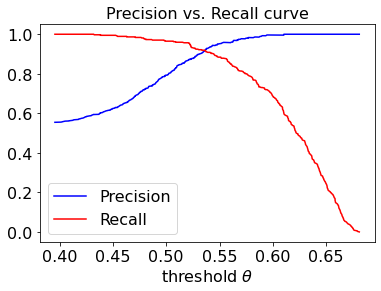

In [25]:
precision, recall, thresholds = precision_recall_curve(Y_train_init, p_hat)

fontsize=16
plt.plot(thresholds, precision[1:], 'b', label='Precision', )
plt.plot(thresholds, recall[1:], 'r', label='Recall')
plt.legend(fontsize=fontsize)
plt.xlabel('threshold', fontsize=fontsize)
plt.xlabel(r'threshold $\theta$', fontsize=fontsize)
plt.title('Precision vs. Recall curve', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

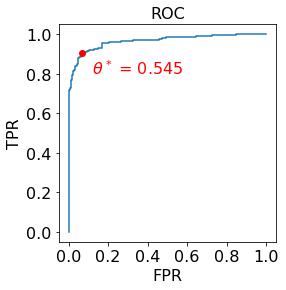

In [26]:
fpr, tpr, thresholds = roc_curve(Y_train_init, p_hat)

fontsize=16
plt.plot(fpr,tpr)

def best_th(fpr, tpr, thresholds):
    d2 = []
    for x,y,th in zip(fpr, tpr, thresholds):
        d2.append(x**2 + (1-y)**2)
    ind = np.argwhere(d2==np.min(d2))[0][0]
    return thresholds[ind], ind

th_star, ind = best_th(fpr, tpr, thresholds)
plt.plot(fpr[ind], tpr[ind], 'ro')
plt.xlabel('FPR', fontsize=fontsize)
plt.ylabel('TPR', fontsize=fontsize)
plt.title('ROC', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.annotate(r'$\theta^*$ = %0.3f'%(th_star), (.12,.8), fontsize=fontsize, c='r')
plt.axis('scaled')
plt.show()

In [27]:
Y_hat = p_hat
Y_hat[p_hat>=th_star] = 1
Y_hat[p_hat<th_star]  = 0

confusion_matrix(Y_train_init, Y_hat)



array([[279,  20],
       [ 36, 335]], dtype=int64)